# Gaussian mixture approach to clustering

## Install edward

In [ ]:
!pip install tensorflow==1.5.0
!pip install edward

## Generate artificial data set

In [2]:
import numpy as np
import matplotlib.pyplot as plt

N = 500  # number of data points
K = 2  # number of components
D = 2  # dimensionality of data

pi = np.array([0.4, 0.6])
mus = [[1, 1], [-1, -1]]
stds = [[0.1, 0.1], [0.1, 0.1]]
x_train = np.zeros((N, 2), dtype=np.float32)
for n in range(N):
  k = np.argmax(np.random.multinomial(1, pi))
  x_train[n, :] = np.random.multivariate_normal(mus[k], np.diag(stds[k]))

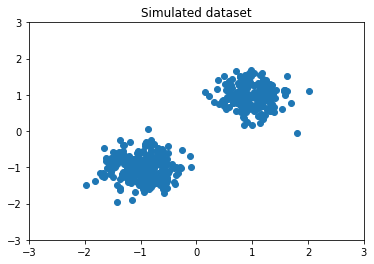

In [3]:
plt.scatter(x_train[:, 0], x_train[:, 1])
plt.axis([-3, 3, -3, 3])
plt.title("Simulated dataset")
plt.show()

## Define the generative model

In [4]:
from edward.models import Dirichlet, InverseGamma, MultivariateNormalDiag, Normal, ParamMixture
import tensorflow as tf

pi = Dirichlet(tf.ones(K))
mu = Normal(tf.zeros(D), tf.ones(D), sample_shape=K)
sigmasq = InverseGamma(tf.ones(D), tf.ones(D), sample_shape=K)
x = ParamMixture(pi, {'loc': mu, 'scale_diag': tf.sqrt(sigmasq)},
                 MultivariateNormalDiag,
                 sample_shape=N)
z = x.cat

## Gibbs sampling

To be able to do Gibbs sampling in Edward we need to define Empricial distributions for our posteriors.

In [5]:
import edward as ed
from edward.models import Empirical

T = 1000  # number of samples

qpi = Empirical(tf.get_variable(
    "qpi/params", [T, K],
    initializer=tf.constant_initializer(1.0 / K)))
qmu = Empirical(tf.get_variable(
    "qmu/params", [T, K, D],
    initializer=tf.zeros_initializer()))
qsigmasq = Empirical(tf.get_variable(
    "qsigmasq/params", [T, K, D],
    initializer=tf.ones_initializer()))
qz = Empirical(tf.get_variable(
    "qz/params", [T, N],
    initializer=tf.zeros_initializer(),
    dtype=tf.int32))

Run the Gibbs sampling.

In [ ]:
inference = ed.Gibbs({pi: qpi, mu: qmu, sigmasq: qsigmasq, z: qz}, data={x: x_train})

inference.run()


Sample from the mean posterior and estimate cluster centres.

In [ ]:
cluster_means = tf.reduce_mean(qmu.sample(1000), 0).eval()
print(cluster_means)